In [1]:
import torch
import torch.nn as nn

In [2]:
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),            
    transforms.Normalize((0.5,), (0.5,))   # optional nhưng rất nên có
])

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
device

'cuda'

In [6]:
train_dataset = datasets.MNIST(
    root='./data',        
    train=True,           
    transform=None,  
    download=True         
)

In [7]:
test_dataset = datasets.MNIST('../data', train=False,download = True, transform=None)


In [8]:
from torch.utils.data import Dataset

In [9]:
class MyData(Dataset):
    def __init__ (self, raw_dataset, transform):
        self.dataset = raw_dataset
        self.transform = transform
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        img, label = self.dataset[idx]
        img = self.transform(img)
        return img, label

In [10]:
train_set = MyData(train_dataset, transform)

In [11]:
test_set = MyData(test_dataset, transform)

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle = True)

In [13]:
class MyNet(nn.Module):
    def __init__ (self,pdrop = 0.4):
        super(MyNet,self).__init__()
        self.dropout = nn.Dropout(pdrop)
        self.relu = nn.ReLU()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.linear1 = nn.Linear(in_features = 32 * 7 * 7, out_features = 256)
        self.linear2 = nn.Linear(in_features = 256, out_features = 128)
        self.linear3 = nn.Linear(in_features = 128, out_features = 10)
    def forward(self,x):
        x = self.cnn1(x)               # (32x1x28x28) => (32x16x28x28)
        x = self.relu(x)
        x = self.maxpool1(x)           # (32x16x28x28) => (32x16x14x14)

        x = self.cnn2(x)               # (32x16x14x14) => (32x32x14x14)
        x = self.relu(x)
        x = self.maxpool2(x)           # (32x32x14x14) => (32x32x7x7)

        x = x.view(x.size(0), -1)   # (32x32x7x7) => (32,1568)

        tensor_x = self.linear1(x)
        tensor_x = self.relu(tensor_x)
        tensor_x = self.dropout(tensor_x)     # (32,256)

        tensor_x = self.linear2(tensor_x)
        tensor_x = self.relu(tensor_x)
        tensor_x = self.dropout(tensor_x)     # (32,128)

        tensor_x = self.linear3(tensor_x)     # (32,10)
        return tensor_x
        

In [14]:
model_cnn = MyNet(pdrop=0.4).to(device)


In [15]:
critetion = nn.CrossEntropyLoss()

In [16]:
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)

In [17]:
epochs = 10

In [18]:
train_loss = []
test_loss = []

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [23]:
for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0.0 
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(img)
        loss = critetion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_training_loss = running_loss / len(train_loader)
    train_loss.append(avg_training_loss)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_training_loss:.4f}")

    model_cnn.eval()
    test_total = 0
    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)
            label = label.to(device)

            test_out = model_cnn(img)
            loss = critetion(test_out, label)
            test_total += loss.item()
    avg_test_loss = test_total / len(test_loader)
    test_loss.append(avg_test_loss)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_test_loss:.4f}")

        

Epoch 1/10 | Train Loss: 0.0515
Epoch 1/10 | Train Loss: 0.0293
Epoch 2/10 | Train Loss: 0.0424
Epoch 2/10 | Train Loss: 0.0313
Epoch 3/10 | Train Loss: 0.0383
Epoch 3/10 | Train Loss: 0.0370
Epoch 4/10 | Train Loss: 0.0351
Epoch 4/10 | Train Loss: 0.0318
Epoch 5/10 | Train Loss: 0.0298
Epoch 5/10 | Train Loss: 0.0279
Epoch 6/10 | Train Loss: 0.0269
Epoch 6/10 | Train Loss: 0.0270
Epoch 7/10 | Train Loss: 0.0243
Epoch 7/10 | Train Loss: 0.0297
Epoch 8/10 | Train Loss: 0.0241
Epoch 8/10 | Train Loss: 0.0299
Epoch 9/10 | Train Loss: 0.0215
Epoch 9/10 | Train Loss: 0.0263
Epoch 10/10 | Train Loss: 0.0200
Epoch 10/10 | Train Loss: 0.0277


In [25]:
torch.save(model_cnn.state_dict(), "model_cnn.pth")


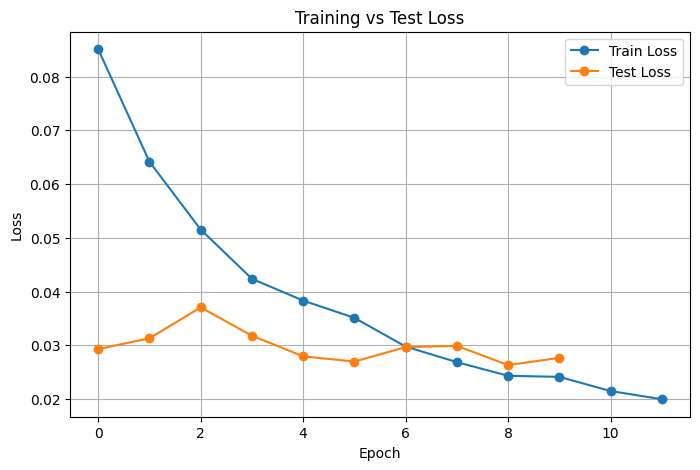

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(test_loss, label='Test Loss', marker='o')
plt.title("Training vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [30]:
def evaluate_model(model, dataloader, device):
    model.eval()     
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return acc, prec, rec, f1


In [31]:
train_acc, train_prec, train_rec, train_f1 = evaluate_model(model_cnn, train_loader, device)
test_acc, test_prec, test_rec, test_f1 = evaluate_model(model_cnn, test_loader, device)

print(f"\n🔹 TRAIN Metrics:")
print(f"Accuracy: {train_acc:.4f} | Precision: {train_prec:.4f} | Recall: {train_rec:.4f} | F1: {train_f1:.4f}")

print(f"\n🔹 TEST Metrics:")
print(f"Accuracy: {test_acc:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f} | F1: {test_f1:.4f}")



🔹 TRAIN Metrics:
Accuracy: 0.9984 | Precision: 0.9984 | Recall: 0.9984 | F1: 0.9984

🔹 TEST Metrics:
Accuracy: 0.9929 | Precision: 0.9929 | Recall: 0.9929 | F1: 0.9929
